# **Saisonnalité et durée de la saisonnalité**

## Configuration

In [10]:
# Set SNT Paths
ROOT_PATH  <- "~/workspace"
CODE_PATH      <- file.path(ROOT_PATH, "code")
CONFIG_PATH    <- file.path(ROOT_PATH, "configuration")
DATA_PATH <- file.path(ROOT_PATH, 'data')
OUTPUT_DATA_PATH <- file.path(DATA_PATH, 'seasonality_rainfall')
PLOTS_PATH <- file.path(ROOT_PATH, "pipelines/snt_seasonality_rainfall/reporting/outputs")

# load util functions
source(file.path(CODE_PATH, "snt_utils.r"))

# List required packages 
required_packages <- c(
    "glue",
    # "terra",
    "ggplot2",
    "stringr",
    "lubridate",
    # "viridis",
    "arrow",
    "sf",
    "reticulate",
    "data.table",
    "RColorBrewer"
)

# Execute function
install_and_load(required_packages)

# Set environment to load openhexa.sdk from the right environment
Sys.setenv(RETICULATE_PYTHON = "/opt/conda/bin/python")
reticulate::py_config()$python
openhexa <- import("openhexa.sdk")

# Load SNT config
config_json <- tryCatch({ jsonlite::fromJSON(file.path(CONFIG_PATH, "SNT_config.json"))},
    error = function(e) {
        msg <- paste0("Error while loading configuration", conditionMessage(e))  
        cat(msg)   
        stop(msg) 
    })

# Required environment for the sf packages
Sys.setenv(PROJ_LIB = "/opt/conda/share/proj")
Sys.setenv(GDAL_DATA = "/opt/conda/share/gdal")

# Configuration variables
COUNTRY_CODE <- config_json$SNT_CONFIG$COUNTRY_CODE
dhis2_dataset <- config_json$SNT_DATASET_IDENTIFIERS$DHIS2_DATASET_FORMATTED

                glue              ggplot2              stringr 
        "glue 1.7.0"      "ggplot2 3.5.2"      "stringr 1.5.2" 
           lubridate                arrow                   sf 
   "lubridate 1.9.4"       "arrow 18.1.0"          "sf 1.0.20" 
          reticulate           data.table         RColorBrewer 
 "reticulate 1.44.1"  "data.table 1.17.8" "RColorBrewer 1.1.3" 


[1] "/opt/conda/bin/python"

In [11]:
# Parameters
minimum_month_block_size <- as.integer(3)
maximum_month_block_size <- as.integer(5)
threshold_for_seasonality <- 0.6
threshold_proportion_seasonal_years <- 0.5

In [12]:
# Global variables
type_of_seasonality <- "rainfall"
formatted_threshold_for_seasonality <- sprintf("%d%%", round(threshold_for_seasonality * 100))
data_source <- 'ERA5'

# space and time columns
admin_level <- 'ADM2'
admin_id_col <- paste(admin_level, toupper('id'), sep = '_')
admin_name_col <- paste(admin_level, toupper('name'), sep = '_')
year_col <- 'YEAR'
month_col <- 'MONTH'
period_cols <- c(year_col, month_col)

## Saisonnalité estimée sur la base des données pluviométriques

In [13]:
# Load spatial file from dataset
spatial_data_filename <- paste(COUNTRY_CODE, "shapes.geojson", sep = "_")

spatial_data <- tryCatch({ get_latest_dataset_file_in_memory(dhis2_dataset, spatial_data_filename) }, 
                  error = function(e) {
                      msg <- paste("Error while loading DHIS2 Shapes data for: " , COUNTRY_CODE, conditionMessage(e))
                      cat(msg)
                      stop(msg)
                      })

[1] "File downloaded successfully from dataset version: SNT_COD_20251120_1045"


In [14]:
# import seasonality data
seasonality_data <- read_parquet(file.path(OUTPUT_DATA_PATH, glue("{COUNTRY_CODE}_rainfall_seasonality.parquet")))
setDT(seasonality_data)

In [15]:
# merge polygon file with seasonality dataset
plot_data <- merge(spatial_data, seasonality_data, by = c('ADM1_NAME','ADM1_ID', admin_id_col, admin_name_col), all = TRUE)

## Create plots

Saving 7 x 7 in image


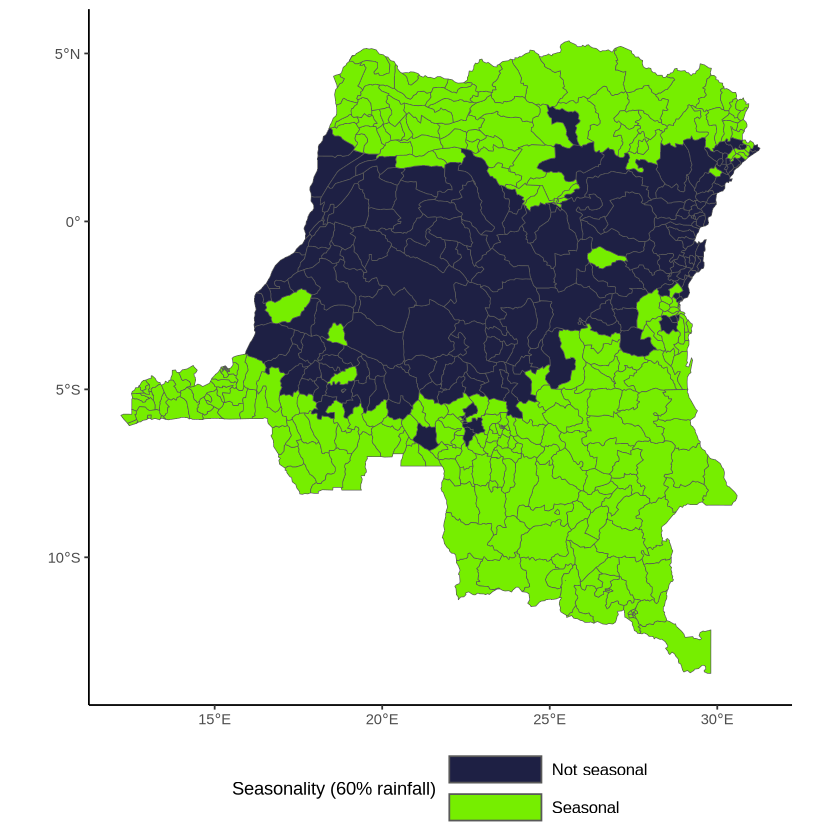

In [ ]:
# the "existence of seasonality" plot
seasonality_plot <- make_seasonality_plot(
  spatial_seasonality_df=plot_data,
  seasonality_colname=paste('SEASONALITY', toupper(type_of_seasonality), sep = "_"),
  title_label=paste("Seasonality:", formatted_threshold_for_seasonality, type_of_seasonality, sep = ' ')
)

filename_seasonality_plot <- paste(COUNTRY_CODE, data_source, admin_level, gsub("\\.", "", as.character(threshold_for_seasonality)), type_of_seasonality, 'seasonality_plot.png', sep = '_')
ggsave(seasonality_plot, file = file.path(PLOTS_PATH, filename_seasonality_plot), dpi = 500)

In [17]:
names(plot_data)

[1] "ADM1_NAME"                        "ADM1_ID"                         
[3] "ADM2_ID"                          "ADM2_NAME"                       
[5] "SEASONALITY_RAINFALL"             "SEASONAL_BLOCK_DURATION_RAINFALL"
[7] "geometry"

Saving 7 x 7 in image


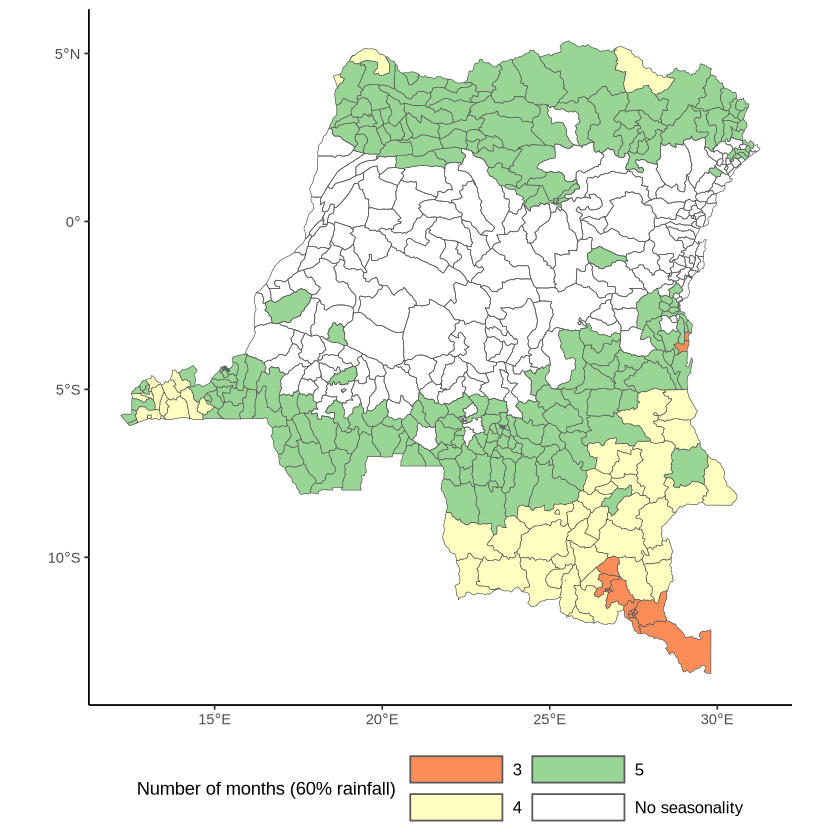

In [ ]:
# the "duration of seasonality" plot
duration_plot <- make_seasonality_duration_plot(
  spatial_seasonality_df=plot_data,
  seasonality_duration_colname=paste('SEASONAL_BLOCK_DURATION', toupper(type_of_seasonality), sep = "_"),
  title_label=paste("Months:", formatted_threshold_for_seasonality, type_of_seasonality, sep=' '),
  palette_name="Spectral",
  none_label="Not seasonal"
)

filename_duration_plot <- paste(COUNTRY_CODE, data_source, admin_level, gsub("\\.", "", as.character(threshold_for_seasonality)), type_of_seasonality, 'duration_plot.png', sep = '_')

ggsave(duration_plot, file = file.path(PLOTS_PATH, filename_duration_plot), dpi = 500)